# Anomaly Detection on COVID-19 County-Level Data

***Setup***: of the > 3000 counties in the US, want to identify those most likely to become 'hotspots'. By this we don't mean places with 'a lot' of cases (such as NYC, which was *bound* to have high numbers, but also has high resources), but places showing anomalous growth in the infection rates, in some way weighted by population/resources. For example, this could identify a subset of places for investigators to focus their attention and for disaster relief managers to be vigilent about sending support.

***Solution***: combine COVID-19 dataset from NYT's public repository (already cleaned, mostly), with Census Bureau's most recent (2018) estimate of population by county. Build features, run Local Outlier Factor analysis.

## Building Dataset

### Update NYT COVID-19 data git repository

Data is from NYT publicly available US COVID-19 data at state and county-level, available [here](https://github.com/nytimes/covid-19-data). Note there are some [geographic exceptions](https://github.com/nytimes/covid-19-data#geographic-exceptions), which we will have to account for later.

In [37]:
import os
import subprocess

# project home directory
project_dir = os.path.abspath('') 

# run git pull on nyt's repository
msg = subprocess.run(['git','pull'],
                     cwd=os.path.join(project_dir,'nyt'),
                     stdout=subprocess.PIPE)

# print git output for good measure
print(msg.stdout.decode('UTF-8'))

Already up to date.



### Load NYT COVID-19 data from file

Data downloaded as CSV file, check data types on subsample.

In [38]:
import pandas as pd

filename = os.path.join(project_dir,'nyt','us-counties.csv')

# load in nyt data, unprocessed
df = pd.read_csv(filename, nrows=10)

# look at data types
print(df.dtypes)

# take a look
df.head(3) 

date      object
county    object
state     object
fips       int64
cases      int64
deaths     int64
dtype: object


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0


Fix column datatypes, load all data.

In [39]:
# will need fips as string for later when combining with Census data
col_dtypes = {'fips' : str}

# also, parse dates as dates!
df = pd.read_csv(filename, dtype=col_dtypes, parse_dates=[0])
df.head(3)

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0


### Cluster Kansas City

NYT data has split Kansas City from the four counties it lies in. To make fair comparison with census data, bin all four counties together along with Kansas City as `county='Kansas City'`, `fips='kscty'`.

First, define helper function to massage the data.

In [40]:
import numpy as np

# helper function to combine Kansas city with four surrounding counties
def combine_kansas_city_covid(df,mo_dfs):

    # initialize dataframe with Kansas City data
    mo_df = df[df['county']=='Kansas City'] 
    
    # set fips to custom 'kscty'
    mo_df.loc[:,'fips'] = 'kscty'
    
    # loop over each of the counties and each of the halves of the merged dataframe
    for d in mo_dfs:
        
        # outer join on 'date' and 'state'
        mo_df = pd.merge(mo_df, d, on=['date','state'], how='outer')
        
        # set N/A cases and deaths from join to zero
        for cases in ('cases_x','cases_y'): 
            mo_df[cases] = mo_df[cases].astype('Int64')
            mo_df.loc[np.isnan(mo_df[cases]),[cases]]=0
        for deaths in ('deaths_x','deaths_y'):
            mo_df[deaths] = mo_df[deaths].astype('Int64')
            mo_df.loc[np.isnan(mo_df[deaths]),[deaths]]=0

        # total cases
        mo_df['cases'] = (mo_df['cases_x'] + mo_df['cases_y']).map(int)
        
        # total deaths
        mo_df['deaths'] = (mo_df['deaths_x'] + mo_df['deaths_y']).map(int)
        
        # set fips, county, state
        mo_df['fips'] = 'kscty'
        mo_df['county'] = 'Kansas City'
        mo_df['state'] = 'Missouri'
        
        # keep only columns we need
        mo_df = mo_df[['date','county','state','fips','deaths','cases']]
        
    # eliminate original 'Kansas City' data, since it's now in mo_df
    df = df[df['county']!='Kansas City'] 
    
    # add new kansas city+ rows
    df = pd.concat([df,mo_df])
    
    # remove each of 'Cass', 'Clay', etc
    for county in counties: 
       df = df[df['county']!=county]
    
    return df

Now apply manipulation to the four effected counties:

In [41]:
# these are the four counties in which Kansas City lies
counties = ['Cass','Clay','Jackson','Platte']

# closure of dataframes for each county surrounding Kansas City
mo_dfs = [df[(df['county']==county) & (df['state']=='Missouri')] for county in counties]

# new dataframe with Kansas City fixed
covid_df = combine_kansas_city_covid(df,mo_dfs)

/Users/wrs/anaconda3/envs/data_science/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### More NYT COVID-19 Cleanup

Since in this dataset, NYC, which is *not* a county and has no `fips`, is its own entity, will assign artificial `fips` of `'nycty'`.

Also, NYT dataset has one county entry of `Unknown`, which has a small number of cases that we ignore.

In [42]:
# use custom fips for NYC b/c NYT data bins NYC too
covid_df.loc[covid_df['county']=='New York City','fips'] = 'nycty'

# remove unknown counties
covid_df = covid_df[covid_df['county']!='Unknown']

# take a look!
covid_df

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0
...,...,...,...,...,...,...
35,2020-04-24,Kansas City,Missouri,kscty,920,34
36,2020-03-16,Kansas City,Missouri,kscty,1,0
37,2020-03-17,Kansas City,Missouri,kscty,4,0
38,2020-03-18,Kansas City,Missouri,kscty,5,0


### US county-level population projections (2018)

Previously downloaded from US Census Bureau [dataset](https://www2.census.gov/programs-surveys/popest/datasets/2010-2018/counties/asrh/cc-est2018-alldata.csv), described [here](https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2018/cc-est2018-alldata.pdf).

First load sample for exploration.

In [43]:
filename = os.path.join(project_dir,'cc-est2018-alldata.csv')

df = pd.read_csv(filename, nrows=5) 

# check it out first
df

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
0,50,1,1,Alabama,Autauga County,1,0,54571,26569,28002,...,607,538,57,48,26,32,9,11,19,10
1,50,1,1,Alabama,Autauga County,1,1,3579,1866,1713,...,77,56,9,5,4,1,0,0,2,1
2,50,1,1,Alabama,Autauga County,1,2,3991,2001,1990,...,64,66,2,3,2,7,2,3,2,0
3,50,1,1,Alabama,Autauga County,1,3,4290,2171,2119,...,51,57,13,7,5,5,2,1,1,1
4,50,1,1,Alabama,Autauga County,1,4,4290,2213,2077,...,48,44,7,5,0,2,2,1,3,1


### Fix `fips` codes in Census data

Note 5-digit `fips` codes in NYT set are STATE+COUNTY, while in Census data STATE and COUNTY are separate and not zero-padded. We correct this below so the two sets can be effectively combined.

In [44]:
# columns we care about
cols = ['TOT_POP', 'COUNTY','AGEGRP','YEAR','STATE']

df1 = pd.read_csv(filename, usecols=cols)

# add new `fips` column by 2-digit state code and concatenating it with 3-digit county code
df1['fips'] = df1['STATE'].map('{:02d}'.format) + df1['COUNTY'].map('{:03d}'.format)

# take a look
df1.head(5)

,STATE,COUNTY,YEAR,AGEGRP,TOT_POP,fips
0,1,1,1,0,54571,01001
1,1,1,1,1,3579,01001
2,1,1,1,2,3991,01001
3,1,1,1,3,4290,01001
4,1,1,1,4,4290,01001


### Extract Most Recent Year (2018) from Census data, with age groups combined

From reading Census docs, `YEAR=11` is 2018, `AGEGRP=0` is all ages.

Also, we only need to get total population per county and county identifier, we discard the rest.

In [45]:
df1 = df1[(df1['YEAR'] == 11) & (df1['AGEGRP']==0)][['fips','TOT_POP']]
df1.head(5)

,fips,TOT_POP
190,01001,55601
399,01003,218022
608,01005,24881
817,01007,22400
1026,01009,57840


### In Census data, modify NYC and Kansas City to match NYT's COVID-19 data

In NYT data, 5 counties that make up NYC are lumped into one entity, while four counties containing Kansas City have had the actual municipality subtracted.

We don't have separate population data for Kansas City, so we lumped all counties into Kansas city in NYT COVID-19 data, and we will do the same here.

In [46]:
# dict of nyc counties and fip codes
nyc_counties = {
    'Bronx'    : '36005',
    'Kings'    : '36047',
    'New York' : '36061',
    'Queens'   : '36081',
    'Richmond' : '36085',
}

# dict of kansas city counties and fip codes
mo_counties = {
    'Cass'    : '29037',
    'Clay'    : '29047',
    'Jackson' : '29095',
    'Platte'  : '29165',
}

# dummy dataframe. New fips are `nycty` and `kscty` just like with COVID datafram
df2 = pd.DataFrame({'fips': ['nycty','kscty'],'TOT_POP' : [0,0]})

# add NYC counties together
for fips in nyc_counties.values():
     df2['TOT_POP'][0] += df1[df1['fips']==fips]['TOT_POP']

# add Kansas City counties together
for fips in mo_counties.values():
     df2['TOT_POP'][1] += df1[df1['fips']==fips]['TOT_POP']

# add new NYC and Kansas City rows
census_df = pd.concat([df1, df2])

# take a look!
census_df

/Users/wrs/anaconda3/envs/data_science/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/wrs/anaconda3/envs/data_science/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,fips,TOT_POP
190,01001,55601
399,01003,218022
608,01005,24881
817,01007,22400
1026,01009,57840
...,...,...
656241,56041,20299
656450,56043,7885
656659,56045,6967
0,nycty,8398748


### Merge Census and COVID datasets

Add population of each county to COVID-19 data to create new dataset.

In [47]:
# left join
df = pd.merge(covid_df, census_df, on='fips', how='left')

# rename 'TOT_POP' column to `population`
df['population'] = df['TOT_POP'].astype('Int64')
df = df.drop(columns=['TOT_POP'])

# take a look
df.head(5)

,date,county,state,fips,cases,deaths,population
0,2020-01-21,Snohomish,Washington,53061,1,0,814901
1,2020-01-22,Snohomish,Washington,53061,1,0,814901
2,2020-01-23,Snohomish,Washington,53061,1,0,814901
3,2020-01-24,Cook,Illinois,17031,1,0,5180493
4,2020-01-24,Snohomish,Washington,53061,1,0,814901


## Anomaly Detection

Here we build some features out of the data, run Outlier Detection, analyze data.

### Setup Feature Parameters

Specify various parameters that go into defining the features.
Notably, `end_date` determines which day we are doing tha analysis for, defaults to today.

In [48]:
import datetime

# specify date to look at, defaults to today
end_date = np.datetime64(datetime.datetime.today())
# end_date = np.datetime64('2020-04-03')

# number of days to average case and death numbers over
n_days_window = 2

# number of days after which an infected individual can be assumed to be not infectious
# anectodally, about 3 weeks
n_days_of_infection = 26

# number of days between exposure and showing symptoms/becoming infectious
n_days_for_incubation = 5

# number of days from exposure to death (post-selected for those who die)
# anecdotally about 10 days after showing symptoms
n_days_to_death = 15

# minimum number of cases a county must have over entire window to be included in the dataset
min_num_cases = 50

### Build features

Build a list of features out of `n_days_window`-length series of `new_cases`, `new_deaths`, `new_case_baseline` (how many cases were there `n_days_for_incubation` ago?), `new_death_baseline` (how many cases were there `n_days_to_death` ago?), and `population`.

In [49]:
feature_list = []

# measure of R_0, i.e. rate of infection per capita infected (at time of exposure)
def feature1(new_cases,new_deaths,
             new_case_baseline,
             new_death_baseline,
             population,
             cases,
             deaths,):
    return np.mean(new_cases/new_case_baseline)
feature_list.append(feature1)               
    
# rate of death per capita infected (at time of exposure)
def feature2(new_cases,new_deaths,
             new_case_baseline,
             new_death_baseline,
             population,
             cases,
             deaths,):
    return np.mean(new_deaths/new_death_baseline)
feature_list.append(feature2)               

# population of county (log, to make smoother and compress)
def feature3(new_cases,new_deaths,
             new_case_baseline,
             new_death_baseline,
             population,
             cases,
             deaths,):
    return np.mean(np.log(population))
feature_list.append(feature3)               

# proxy for fraction of population that is infected (should be somewhat robust to poor testing)
def feature4(new_cases,new_deaths,
             new_case_baseline,
             new_death_baseline,
             population,
             cases,
             deaths,):
    return np.mean(new_case_baseline/population)
feature_list.append(feature4)               

# proxy for fraction of population that has died (should be somewhat robust to poor testing)
def feature5(new_cases,new_deaths,
             new_case_baseline,
             new_death_baseline,
             population,
             cases,
             deaths,):
    return np.mean(deaths/population)
feature_list.append(feature5)               

In [50]:
# helper function finds last True expression in a boolean array
def findlast(bool_array):
    idx = len(bool_array)-1
    bool = bool_array[idx]
    while not bool:
        idx -= 1
        if idx <= 0:
            break
        bool = bool_array[idx]
    return idx

In [51]:
# get unique fips and associated county and state names
FIPS, INDS = np.unique(np.array(df['fips']), return_index=True)
COUNTIES = np.array(df['county'])[INDS]
STATES = np.array(df['state'])[INDS]

# initialize sample data
X = []
fips = []
counties = []
states = []

for ind in range(len(FIPS)):
    
    fip = FIPS[ind]
    
    # select only one county
    x = df[df['fips']==fip]
    
    # get dates for that county, and start and end indices for time-window
    dates = np.array(x['date'])
    start_date = end_date - np.timedelta64(n_days_window,'D')
    start_idx = findlast(dates <= start_date)
    end_idx = findlast(dates <= end_date)
    
    # throw away county if time series is not long enough to support features
    if start_idx < max(n_days_of_infection, n_days_for_incubation, n_days_to_death):
        continue

    # helper functions for getting new_cases and deaths
    def differential(array, window):
        return array[start_idx:end_idx] - array[start_idx-window:end_idx-window]

    # helper functions for get baslines
    def shift(array, shift):
        return array[start_idx-shift:end_idx-shift]

    population = x['population'].mean()
    cases = np.array(x['cases'])
    deaths = np.array(x['deaths'])
    
    # if number of cases too small (set by min_num_cases), throw it away
    if cases[start_idx] < min_num_cases:
        continue
        
    # build list of counties that meet all criteria for keeping
    fips.append(fip)
    counties.append(COUNTIES[ind])
    states.append(STATES[ind])
    
    # extract relevant dates
    dates = np.array(x['date'])[start_idx:end_idx]
    
    # build feature inputs
    currently_infected = differential(cases,n_days_of_infection)
    new_cases = differential(cases,1)
    new_deaths = differential(deaths,1)
    new_case_baseline = shift(cases, n_days_for_incubation)
    new_death_baseline = shift(cases, n_days_to_death)
    cases = shift(cases, 0)
    deaths = shift(deaths, 0)
    
    # compute features
    features = []
    for feature in feature_list:
        features.append(feature(new_cases,new_deaths,
                                new_case_baseline,
                                new_death_baseline,
                                population,
                                cases,
                                deaths,
                               )
                       )
    
    X.append(np.array(features))
    
# turn samples into ndarray, and list of counties and states, for boolean indexing later
X = np.asarray(X)
counties = np.asarray(counties)
states = np.asarray(states)

### Visualize Data according to defined features

This is to get a sense about whether these features could highlight anomalies or if they just show large cities, for example.

First, normalize the data:

In [52]:
from sklearn import preprocessing

# mean-center and normalize data, using 'robust' b/c outlier problem
X = preprocessing.robust_scale(X)

Text(0, 0.5, 'new death rate')

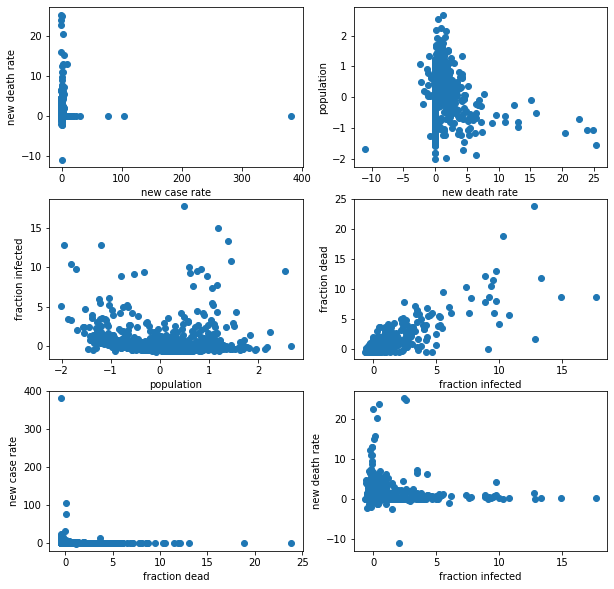

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

plt.subplot(321)
plt.scatter(X[:,0],X[:,1])
plt.xlabel("new case rate")
plt.ylabel("new death rate")

plt.subplot(322)
plt.scatter(X[:,1],X[:,2])
plt.xlabel("new death rate")
plt.ylabel("population")

plt.subplot(323)
plt.scatter(X[:,2],X[:,3])
plt.xlabel("population")
plt.ylabel("fraction infected")

plt.subplot(324)
plt.scatter(X[:,3],X[:,4])
plt.xlabel("fraction infected")
plt.ylabel("fraction dead")

plt.subplot(325)
plt.scatter(X[:,4],X[:,0])
plt.xlabel("fraction dead")
plt.ylabel("new case rate")

plt.subplot(326)
plt.scatter(X[:,3],X[:,1])
plt.xlabel("fraction infected")
plt.ylabel("new death rate")

### Outlier Detection

Perform Local Outlier Factor analysis, sort states and county according to outlier score, print results.

Top hit is Marion County, Ohio, where there is a known massive outbreak in a prison.
Next is Waldo county in Maine, does not seem to be reflected in current news.
Many of the following dozen or so are the locations of Meat-packing plants that have outbreaks, currently in the [news](https://www.usatoday.com/in-depth/news/investigations/2020/04/22/meat-packing-plants-covid-may-force-choice-worker-health-food/2995232001/).

In [55]:
from sklearn.neighbors import LocalOutlierFactor

# run in parallel, auto-detect anomaly fraction
lof = LocalOutlierFactor(n_jobs=-1, contamination="auto")

# detect outliers
y_pred = lof.fit_predict(X)

# get outlier scores
scores = lof.negative_outlier_factor_
perm = np.argsort(scores)
scores_sorted = scores[perm]
counties_sorted = counties[perm]
states_sorted = states[perm]
y_pred_sorted = y_pred[perm]

# print results
print('%i anomalies detected, %2.2f%% counties that meet case threhold:\n' % (sum(y_pred==-1),100*sum(y_pred==-1)/len(counties)))
print('%5s %20s %20s\n' % ('SCORE','STATE','COUNTY'))
for p in range(len(y_pred_sorted)):
    if y_pred_sorted[p]==-1:
        print('%5.2f %20s %20s' % (-scores_sorted[p], states_sorted[p], counties_sorted[p]))

66 anomalies detected, 7.98% counties that meet case threhold:

SCORE                STATE               COUNTY

68.25            Tennessee              Bledsoe
20.00             Virginia          Southampton
14.54             Nebraska              Madison
 8.39              Alabama               Wilcox
 5.92             Maryland                 Kent
 4.88             Nebraska               Dawson
 4.10             Arkansas              Lincoln
 3.75       North Carolina              Robeson
 3.65        West Virginia           Monongalia
 3.28            Tennessee                Macon
 3.19               Kansas                 Lyon
 3.14              Alabama           Tuscaloosa
 3.13            Louisiana            Bienville
 3.12       North Carolina           Cumberland
 3.09              Georgia              Chatham
 3.03               Kansas                 Ford
 3.02         Pennsylvania               Butler
 3.01             Colorado               Morgan
 2.98             Oklah